In [20]:
%matplotlib inline
import calendar
from sklearn.preprocessing import Normalizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats
import math

# Jupyter notebook settings
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [24, 8]

# Dataset feature constants
TARGET_CLASS = ["DEP_DEL15"]
CATEGORICAL = ["CARRIER_NAME", "DEPARTING_AIRPORT", "PREVIOUS_AIRPORT", "DEP_TIME_BLK"]
CONTINUOUS = ["FLT_ATTENDANTS_PER_PASS", "GROUND_SERV_PER_PASS", "LATITUDE", "LONGITUDE",
              "PRCP", "SNOW", "SNWD", "TMAX", "AWND"]
DISCRETE = ["MONTH", "DAY_OF_WEEK", "DISTANCE_GROUP", "SEGMENT_NUMBER",
            "CONCURRENT_FLIGHTS", "NUMBER_OF_SEATS", "AIRPORT_FLIGHTS_MONTH", "AIRLINE_FLIGHTS_MONTH",
            "AIRLINE_AIRPORT_FLIGHTS_MONTH", "AVG_MONTHLY_PASS_AIRPORT", "AVG_MONTHLY_PASS_AIRLINE", "PLANE_AGE"]

<figure>
  <IMG SRC="https://www.colorado.edu/cs/profiles/express/themes/cuspirit/logo.png" WIDTH=50 ALIGN="right">
</figure>

# Semester Project - Part 1
*CSPB 3022 Data Science Algorithms - Spring 2022*

* Author: Thomas Cochran

* Github: https://github.com/t-cochran/CSPB-3022-Data-Science-Project

## Project Topic

**Project goal:**

The goal of this project is to create a binary classifier that predicts whether a domestic flight will be delayed or not. 

**Type of problem:**

This is a binary classification problem with target classes: `delayed` and `not delayed`. The target class `DEP_DEL15` classifies any flight as delayed if the departure time exceeds 15 minutes.

**Project motivation:**

Most of us have encountered flight delays at some point in our lives. They can be difficult to work around, especially if you have a connecting flight. So, the motivation for this project is to identify when these delays may or may not occur. If we anticipate a delay, perhaps we could plan around it ahead of time. Or, at the very least, we could mentally prepare ourselves and hope we get an aisle seat!


## Dataset

**Dataset Source:**

The dataset used in this project is from kaggle ([source](https://www.kaggle.com/datasets/threnjen/2019-airline-delays-and-cancellations)) and is located in file: `dataset/full_data_flightdelay.csv`

Each row of the dataset corresponds to a domestic airline departure flight and its associated weather for the year of 2019. This dataset has been wrangled and merged by the kaggle source from the following primary sources:

1. Bureau of Transportation statistics: [Link](https://www.transtats.bts.gov/databases.asp?Z1qr_VQ=E&Z1qr_Qr5p=N8vn6v10&f7owrp6_VQF=D)
2. National Centers for Environmental Information (NOAA): [Link](https://www.ncdc.noaa.gov/cdo-web/datasets)

The departure data from the Bureau of Transportation statistics consists primarily of monthly performance reports that contain a plethora of features for domestic departure flights. The NOAA data is merged with the above departure data, and this adds some interesting features which may contribute to flight delays, such as departure wind, snowfall, and precipitation.

**Dataset size and features:**

The dataset is quite large. Each row corresponds to a single domestic departure and the dataset contains over 6 million domestic departures for the year of 2019. Here is a summary of the dataset's contents:

* 1.27 GB size
* 6,489,062 rows 
* 26 features 

There are 5 categorical and 21 numeric features. The target class is `DEP_DEL15` and it is a binary feature that indicates whether or not a departure flight was delayed by at least 15 minutes. A description of each feature can be found in the file `dataset/documentation.md`.

In [21]:
# Load the dataset
df = pd.read_csv('../dataset/full_data_flightdelay.csv', dtype='unicode')

Here is a brief look at some of the features in the dataset:

In [22]:
# A brief look at a random sample of departure flights and some of their features
display(df[['MONTH', 'DEP_DEL15', 'CARRIER_NAME', 'NUMBER_OF_SEATS', 
            'DEPARTING_AIRPORT', 'PLANE_AGE', 'FLT_ATTENDANTS_PER_PASS', 'PRCP', 'SNOW']].sample(n=8, replace=False))

,MONTH,DEP_DEL15,CARRIER_NAME,NUMBER_OF_SEATS,DEPARTING_AIRPORT,PLANE_AGE,FLT_ATTENDANTS_PER_PASS,PRCP,SNOW
2178347,5,0,SkyWest Airlines Inc.,66,Chicago O'Hare International,14,3.419267401443636e-05,0.0,0.0
3939448,8,0,Delta Air Lines Inc.,191,Detroit Metro Wayne County,1,0.0001441658849878598,0.0,0.0
665753,2,0,Delta Air Lines Inc.,180,Palm Beach International,2,0.0001441658849878598,0.0,0.0
159228,1,0,Endeavor Air Inc.,50,Detroit Metro Wayne County,15,0.0,0.0,0.0
3692642,7,0,Southwest Airlines Co.,143,Chicago Midway International,14,6.178236301460919e-05,0.0,0.0
4338326,9,1,American Eagle Airlines Inc.,50,Dallas Fort Worth Regional,15,0.00034840766560500434,0.0,0.0
2057548,5,0,American Airlines Inc.,160,Dallas Fort Worth Regional,2,9.82082928995461e-05,0.0,0.0
6218055,12,1,SkyWest Airlines Inc.,66,Douglas Municipal,10,3.419267401443636e-05,0.01,0.0


## Data cleaning:

**Setting data types**

The data types for each feature are listed as `object` which means they are encoded as a string of varying length. The first cleaning step will be to cast each feature to an appropriate type that we can work with. 

Note: the constants below (e.g. `TARGET_CLASS`, `CATEGORICAL`) are lists that that separate different types of features in the dataset. This was done for readability. Each of these lists can be found at the top of this notebook.

In [23]:
# Cast groups of features from strings to an appropriate data type
df[TARGET_CLASS] = df[TARGET_CLASS].astype(int)
df[CATEGORICAL] = df[CATEGORICAL].astype(str)
df[CONTINUOUS] = df[CONTINUOUS].astype(float)
df[DISCRETE] = df[DISCRETE].astype(int)

# List the features of the first 8 columns and their datatypes
display(df.iloc[:, 0:7].dtypes)

MONTH                  int32
DAY_OF_WEEK            int32
DEP_DEL15              int32
DEP_TIME_BLK          object
DISTANCE_GROUP         int32
SEGMENT_NUMBER         int32
CONCURRENT_FLIGHTS     int32
dtype: object

The target class `DEP_DEL15` uses a binary value of type `int` to indicate whether or not a flight has been delayed by at least 15 minutes. Numeric features can be continuous or discrete, which are `float` or `int` respectively. Categorical features, such as airline carrier name, are of type `string` which appear as type `object` in the above list of data types.

**Checking for missing values**

Next I will look for any missing values by looking for features with `np.nan` values:


In [24]:
# Sum NaN values in all columns
missing_vals = df.isnull().sum()
print(f"Total missing values in dataset: {missing_vals.sum()}")

Total missing values in dataset: 0


There don't appear to be any missing values in the form of `np.nan`, however there are some empty categorical features listed with `NONE`:

In [25]:
# Search the dataframe for "NONE" string values
none_vals = df[df.eq("NONE").any('columns')]

# Print the name of columns with NONE value and the percentage of the dataset with NONE values
print(f"Columns with NONE values: {df.columns[df.eq('NONE').any('rows')]}")
print(f"Percent of dataset with NONE values: {(len(none_vals) / len(df) * 100):.2f}%")

Columns with NONE values: Index(['PREVIOUS_AIRPORT'], dtype='object')
Percent of dataset with NONE values: 22.33%


22.3% of the dataset has rows with `NONE` values, so it would be costly to drop all rows with this missing value. However, this affects only one feature: `PREVIOUS_AIRPORT`. Given these circumstances, I will keep these rows in the dataset and note that there will be a feature imbalance with `PREVIOUS_AIRPORT`.

## Exploratory Data Analysis (EDA):

**Overview: Why EDA?**

Exploratory data analysis is a collection of methods that investigate characteristics and patterns in the dataset which can improve our understanding of the features and their relationships.


**How EDA will be performed:**

I will be using EDA to visualize a variety of relationships between features and the target class `DEP_DEL15`. Some of these visualizations will seek to answer questions:

1. What numeric features are highly correlated? Are any redundant?
2. How does the frequency of flight delays vary by month or day of the week?
3. Are there certain airlines that experience more frequent delays?
4. Do more delays occur with older planes?

I will begin by looking at some basic descriptive statistics of the numeric features for delayed flights and then explore these questions.

**Mean and standard deviation of numeric features**

The goal here is to have a quick first pass look at the numeric features for delayed and on-time flights in an effort to see where the averages are, and where there may be some differences. 

First I will compute the mean and standard deviation for delayed flights:

In [26]:
# Select numeric features, exluding month and day of week
numeric = df[TARGET_CLASS + CONTINUOUS + DISCRETE]
numeric = numeric.loc[:, ~numeric.columns.isin(['MONTH', 'DAY_OF_WEEK'])]

# Select delayed flights only
delayed_numeric = numeric[numeric['DEP_DEL15'] == 1]

# Compute the mean and standard deviation for numeric features of delayed flights
print("DELAYED FLIGHTS:")
display(delayed_numeric.describe().loc[['mean', 'std']].applymap('{:.2f}'.format))

DELAYED FLIGHTS:


,DEP_DEL15,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,PLANE_AGE
mean,1.00,0.00,0.00,36.71,-93.25,0.16,0.06,0.13,71.13,8.72,3.90,3.47,28.24,134.88,13174.01,63211.75,3579.94,1645375.69,7828102.68,11.62
std,0.00,0.00,0.00,5.25,16.81,0.43,0.49,0.86,19.24,3.78,2.38,1.77,21.30,46.48,8731.56,35100.32,4094.56,1095573.89,5043404.98,6.77


Next, I will compute the same for on-time flights:

In [27]:
# Select on-time flights only
ontime_numeric = numeric[numeric['DEP_DEL15'] == 0]

# Compute the mean and standard deviation for numeric features of on-time flights
print("ON-TIME FLIGHTS:")
display(ontime_numeric.describe().loc[['mean', 'std']].applymap('{:.2f}'.format))

ON-TIME FLIGHTS:


,DEP_DEL15,FLT_ATTENDANTS_PER_PASS,GROUND_SERV_PER_PASS,LATITUDE,LONGITUDE,PRCP,SNOW,SNWD,TMAX,AWND,DISTANCE_GROUP,SEGMENT_NUMBER,CONCURRENT_FLIGHTS,NUMBER_OF_SEATS,AIRPORT_FLIGHTS_MONTH,AIRLINE_FLIGHTS_MONTH,AIRLINE_AIRPORT_FLIGHTS_MONTH,AVG_MONTHLY_PASS_AIRPORT,AVG_MONTHLY_PASS_AIRLINE,PLANE_AGE
mean,0.00,0.00,0.00,36.70,-94.49,0.09,0.02,0.08,71.55,8.25,3.80,2.95,27.74,133.47,12570.41,62901.99,3431.10,1575403.75,7811906.61,11.51
std,0.00,0.00,0.00,5.56,18.15,0.32,0.26,0.69,18.14,3.56,2.38,1.74,21.56,46.44,8860.97,34212.30,4286.35,1129931.10,5047687.73,6.97


The average daily percipitation and snow (`PRCP`, `SNOW`; in inches) is lower for on-time flights, but both feature means have a relatively large variance. The mean maximum wind speed (`AWND`; in knots) is also lower for on-time flights with a lower variance relative to its mean than `PRCP` and `SNOW`. The average age of a plane is similar for delayed and on-time flights, and so is the average `NUMER_OF_SEATS`. There is a clear difference between the average monthly passengers at the airport (`AVG_MONTHLY_PASS_AIRPORT`), which is larger for delayed flights than for on-time flights.

**Correlation matrix**

A correlation matrix is a collection of correlation coefficients between features in a dataset. This is useful because it can identify strong positive or negative linear relationships between features. If a pair of features have a very strong linear relationship, then they may be redundant; that is, one can be substituted for the other. 

In this section, I will pair numeric features and then create a correlation matrix. Using the correlation matrix, I will identify which features are highly correlated and then remove redundant features using a simple heuristic: If two features have $|\rho| >= 0.90$, I will remove the feature with a lower correlation to our target class.

In an effort to better visualize the relationship between features, I will normalize samples and then plot the correlation matrix as a heatmap using the seaborn library referenced here ([Source](https://seaborn.pydata.org/examples/many_pairwise_correlations.html)):

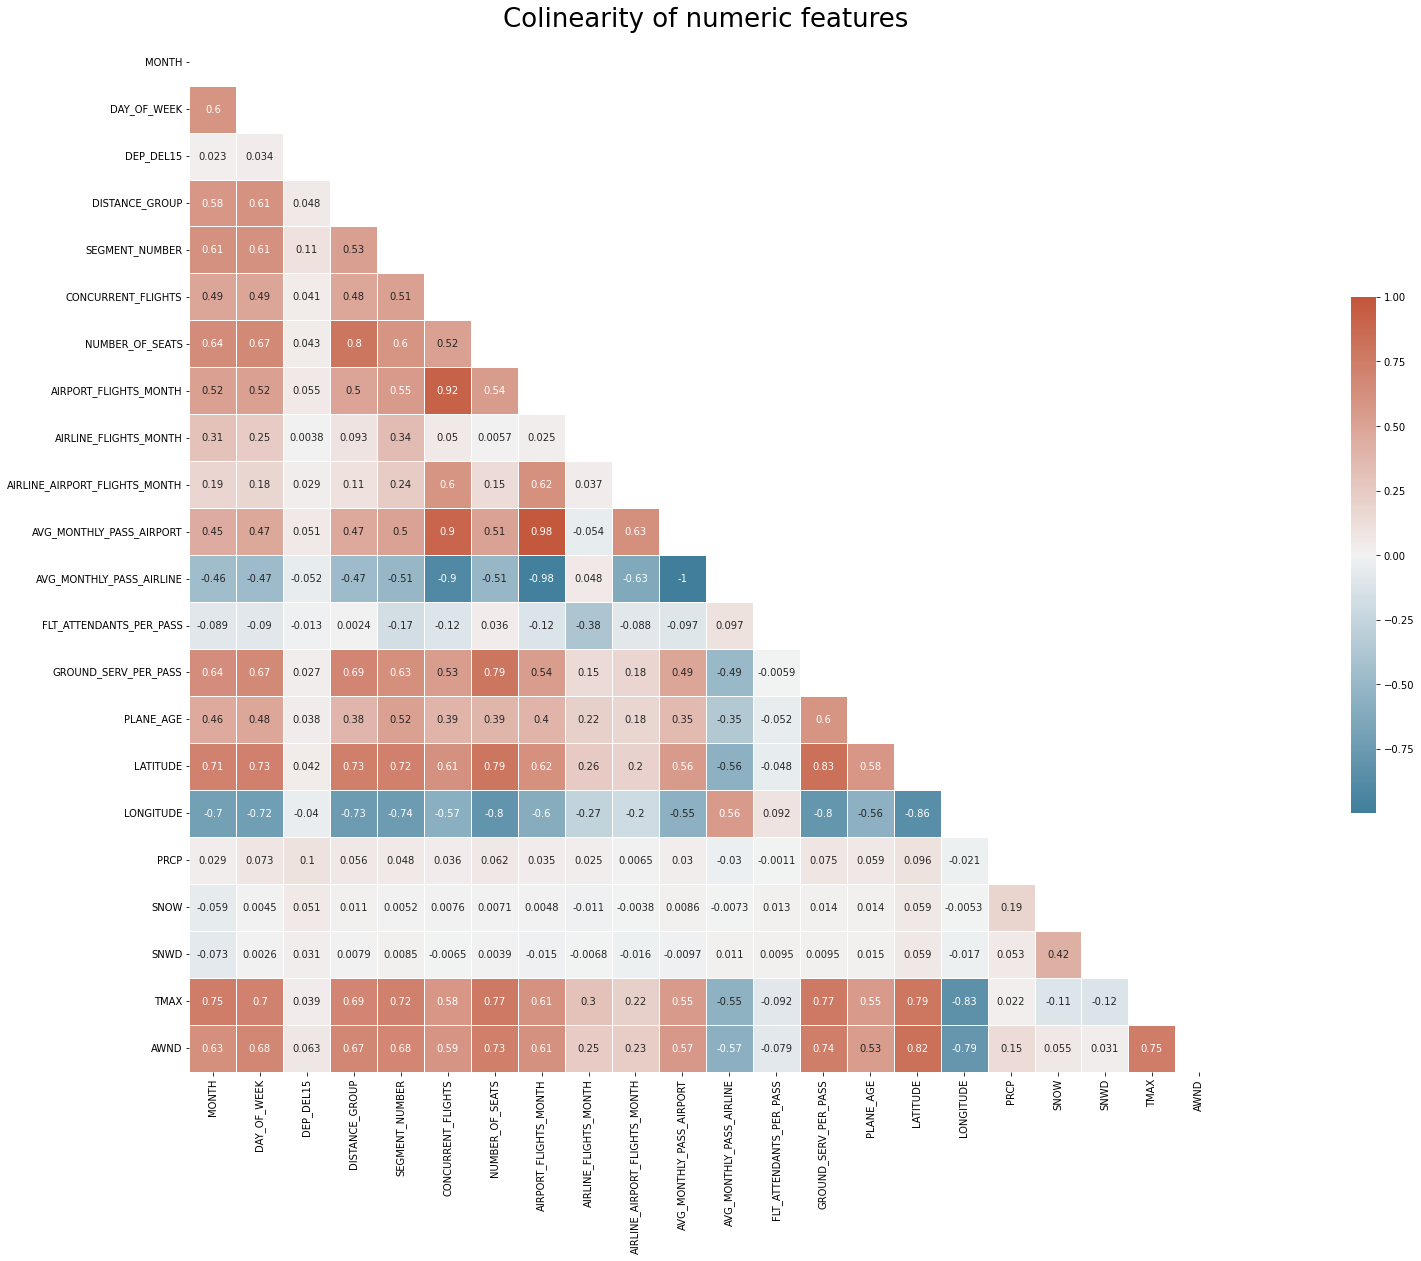

In [28]:
# Select only the numeric features from the dataset
numeric_features_df = df.select_dtypes(['int32', 'float64'])

# Normalize and then compute a pairwise correlation of numeric columns
normalized_pd = pd.DataFrame(Normalizer().fit_transform(numeric_features_df), columns = numeric_features_df.columns)
corr = normalized_pd.corr('spearman')

# Mask the upper triangle of the heatmap and create a diverging colormap
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Create the heatmap
f, ax = plt.subplots(figsize=(46, 19))
corr_heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, 
                           linewidths=.5, cbar_kws={"shrink": .5}, annot=True, 
                           annot_kws={"fontsize":10})

# Set the heatmap title
corr_heatmap.set_title('Colinearity of numeric features', fontdict={'fontsize':26}, pad=12);

The heatmap shows some highly correlated numeric features. For example, the average airport flights per month (`AIRPORT_FLIGHTS_MONTH`) is highly correlated with the average airport departing passengers per month (`AVG_MONTHLY_PASS_AIRPORT`), which we may expect.

The following algorithm should target and remove highly correlated features from the dataset using the heuristic above.

In [29]:
# Select the upper triangle of correlation matrix using our mask
corr_matrix = corr.where(cond=mask)

# Remove redundant features according to heuristic:
# If |p| >= 0.90 remove the feature less correlated to target class 'DEP_DEL15'
redundant_features = []
for col in corr_matrix:
    current_column = corr_matrix[col]       # Iterate over columns in the correlation matrix
    if current_column.name == 'DEP_DEL15':  # Ignore our target class
        continue
    else:
        for row in current_column.index:    # Select each row in the current column
            if current_column.name == row:  # Ignore correlation between the same row and column
                continue
            if np.abs(current_column[row]) >= 0.90:                  # Select highly correlated |p|>=0.90 features
                target_class_row = corr_matrix.loc['DEP_DEL15'][row] # Check the correlation with our target class
                target_class_col = corr_matrix.loc['DEP_DEL15'][col]
                if target_class_row >= target_class_col:             # Remove feature with lower correlation to target
                    redundant_features.append(current_column.name)
                else:
                    redundant_features.append(row)

# Print and drop redundant features
df.drop(set(redundant_features), axis=1, inplace=True)
print(f"Dropped redundant features:\n{set(redundant_features)}")

Dropped redundant features:
{'AVG_MONTHLY_PASS_AIRLINE', 'AVG_MONTHLY_PASS_AIRPORT', 'CONCURRENT_FLIGHTS'}


**Flight delay frequency by month and weekday**

In this section, I will be investigating how delays vary over months and days of the week. My intuition tells me that holiday months and Mondays should have a higher incidence of delays due to more congestion at the airport.

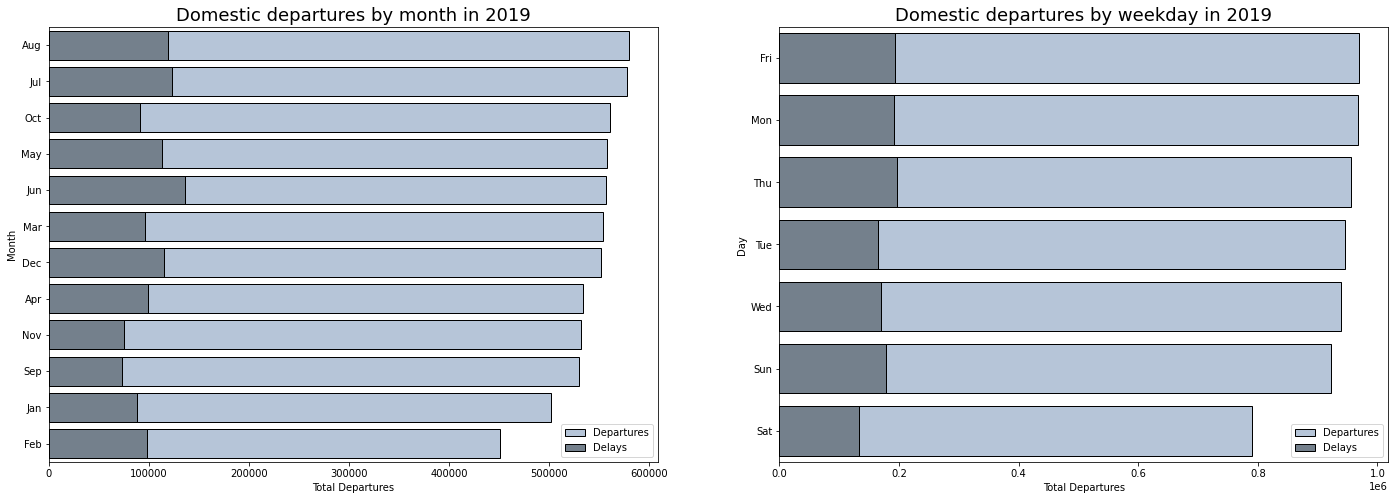

In [30]:
# Create dataframes to organize and sort the frequency data
month_df = pd.DataFrame({
    'MONTHLY_TOTAL'  :  df.groupby(['MONTH']).size(),
    'MONTHLY_DELAYS' :  df[df['DEP_DEL15'] == 1].groupby(['MONTH']).size(),
})
day_df = pd.DataFrame({
    'WEEKDAY_TOTAL'  :  df.groupby(['DAY_OF_WEEK']).size(),
    'WEEKDAY_DELAYS' :  df[df['DEP_DEL15'] == 1].groupby(['DAY_OF_WEEK']).size()
})

# Sort by total departures
month_df = month_df.sort_values(by=['MONTHLY_TOTAL'], ascending=False)
day_df = day_df.sort_values(by=['WEEKDAY_TOTAL'], ascending=False)

# Plot frequency of monthly delays
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.barplot(x="MONTHLY_TOTAL", y=month_df.index, data=month_df, ax=ax1, order=month_df.index, 
            edgecolor='black', color="lightsteelblue", label="Departures", orient="h")
sns.barplot(x="MONTHLY_DELAYS", y=month_df.index, data=month_df, ax=ax1, order=month_df.index, 
            edgecolor='black', color="slategray", label="Delays", orient="h")

# Plot frequency of week day delays
sns.barplot(x="WEEKDAY_TOTAL", y=day_df.index, data=day_df, ax=ax2, order=day_df.index, 
            edgecolor='black', color="lightsteelblue", label="Departures", orient="h")
sns.barplot(x="WEEKDAY_DELAYS", y=day_df.index, data=day_df, ax=ax2, order=day_df.index, 
            edgecolor='black', color="slategray", label="Delays", orient="h")

# Configure plot labels
ax1.set_title('Domestic departures by month in 2019', fontdict={'fontsize':18})
ax2.set_title('Domestic departures by weekday in 2019', fontdict={'fontsize':18})
ax1.set_yticklabels(['Aug', 'Jul', 'Oct', 'May', 'Jun', 'Mar', 'Dec', 'Apr', 'Nov', 'Sep', 'Jan', 'Feb'])
ax2.set_yticklabels(['Fri', 'Mon', 'Thu', 'Tue', 'Wed', 'Sun', 'Sat'])
ax1.legend(ncol=1, loc="lower right", frameon=True), ax2.legend(ncol=1, loc="lower right", frameon=True)
ax1.set_xlabel("Total Departures"), ax1.set_ylabel("Month")
ax2.set_xlabel("Total Departures"), ax2.set_ylabel("Day");

Since I did not normalize the departures, it is difficult to say whether or not Saturday's have fewer delays than other week days. This is because Saturday's also have the lowest total departures. However, I thought it would be interesting to look at the raw frequency of departures since we can see which months and weeks are the most busy (i.e. have the most departures).

The month of August has the most departures, followed by July amd the lowest frequency of departures occurs in February and Saturday. The single largest number of delays occur in June and on Thursday. However, the all days of the week appear to have a comparable number of delays. 

**Distribution of plane age in delayed and on-time departures**

In this section, I will investigate whether delayed flights involve a larger number of older planes than on-time planes. In order to do this, I will plot the relative frequency of planes by age for both delayed and on-time flights. In the plot, I will overlay bar graphs for on-time and delayed flights in an effort to visualize differences.

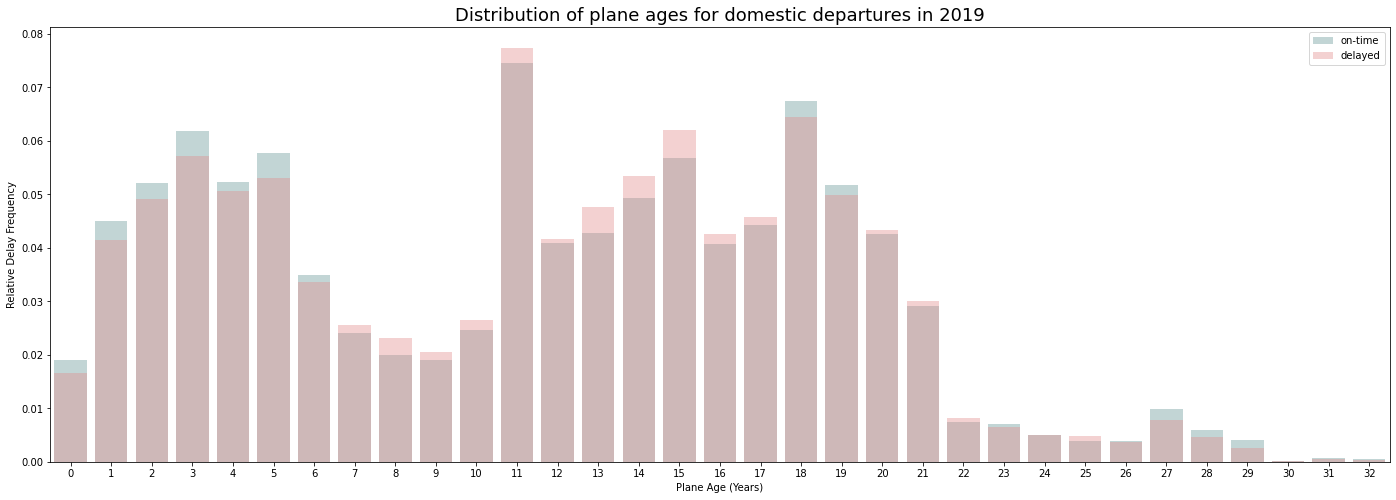

In [31]:
# Select delayed and ontime departures and sort by plane age
ontime_df = df[df['DEP_DEL15'] == 0].sort_values(['PLANE_AGE'], ascending=True)
delay_df = df[df['DEP_DEL15'] == 1].sort_values(['PLANE_AGE'], ascending=True)

# Compute the relative frequency of planes for each age group
ontime_df['AGE_PCT'] = ontime_df['PLANE_AGE'].map(ontime_df['PLANE_AGE'].value_counts(normalize=True))
delay_df['AGE_PCT'] = delay_df['PLANE_AGE'].map(delay_df['PLANE_AGE'].value_counts(normalize=True))

# Pair the age percentage with each unique plane age
ontime_df = ontime_df.groupby(['PLANE_AGE']).head(n=1)[['PLANE_AGE', 'AGE_PCT']]
delay_df = delay_df.groupby(['PLANE_AGE']).head(n=1)[['PLANE_AGE', 'AGE_PCT']]

# Plot the percentage of planes in each age group for delayed and on-time flights
ax = plt.subplots()
ax = sns.barplot(x=ontime_df.PLANE_AGE,y=ontime_df.AGE_PCT,color='cadetblue',label='on-time',alpha=0.4)
ax = sns.barplot(x=delay_df.PLANE_AGE,y=delay_df.AGE_PCT,color='lightcoral', label='delayed',alpha=0.4)
ax.set_title('Distribution of plane ages for domestic departures in 2019', fontdict={'fontsize':18})
ax.set_xlabel("Plane Age (Years)"), ax.set_ylabel("Relative Delay Frequency")
plt.legend();

The difference between on-time and delayed departures appears to be quite small. The left hand side of the graph suggests that on-time flights do use younger aircraft slightly more frequently than delayed flights. The middle of the graph suggests that delayed flights do use older aircraft slightly more frequently than on-time flights. Additionally, I find it interesting that there is a large gap between the ages of 6 and 10. Are thes planes grounded for some unknown reason? Is the dataset complete?

**Distribution of delays across airlines**

Next I will plot the distribution of delays across different airlines to see if there are any particular carriers that are better or worse at avoiding delays. Perhaps there are certain airlines we should avoid?

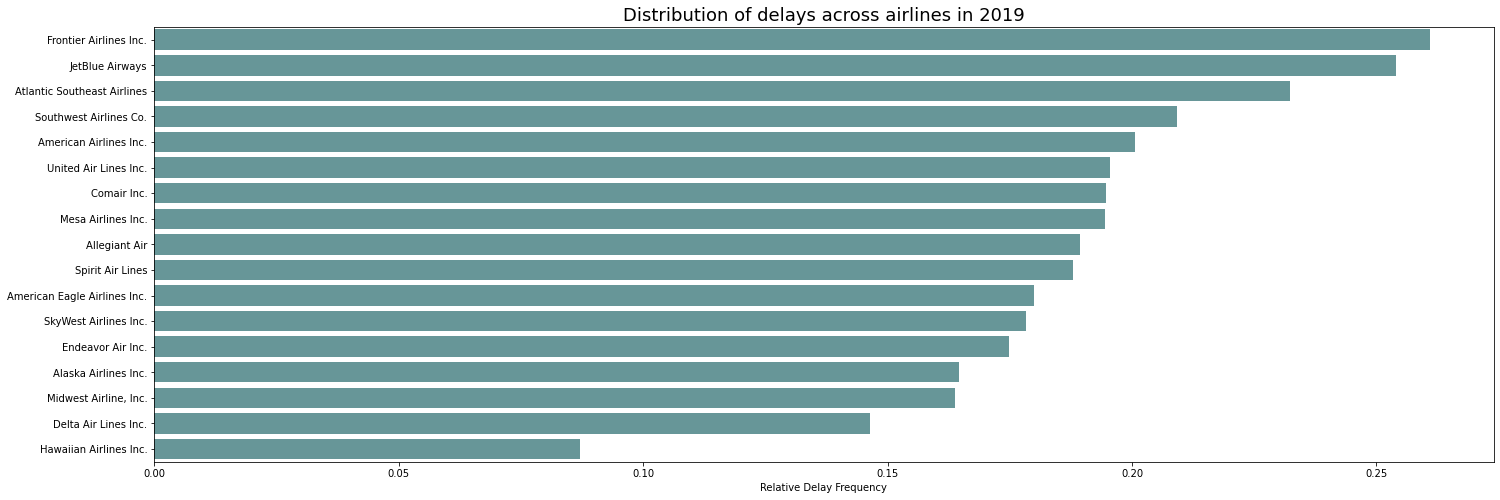

In [43]:
# Select departures grouped by CARRIER_NAME then compute the relative frequency of delays
delay_df = df.groupby(['CARRIER_NAME'])['DEP_DEL15'].value_counts(normalize=True).sort_values(ascending=False)

# Select only delayed flights
delay_df = delay_df.iloc[delay_df.index.get_level_values('DEP_DEL15') == 1]

# Get x and y axis from the delay_df series
x = delay_df.values
y = delay_df.index.get_level_values('CARRIER_NAME')

# Plot the distribution of delays
ax = plt.subplots()
ax = sns.barplot(x=x,y=y,color='cadetblue', orient="h")
ax.set_title('Distribution of delays across airlines in 2019', fontdict={'fontsize':18})
ax.set_xlabel("Relative Delay Frequency"), ax.set_ylabel("");

The clear winner here is Hawaiin Airlines which has the lowest relative delay frequency. The top two airlines are Frontier and Jetblue. I find this a little amusing because I often booked Frontier for flights to CU Boulder and I often encountered delays.

**Distribution of delays across departing airports**

This section is similar to the last, however instead of airline carriers I am plotting the relative frequency of delays over departing airports in the dataset. As with airline carrier, this should be interesting to see if there exist certain airports that are rife with delays. 

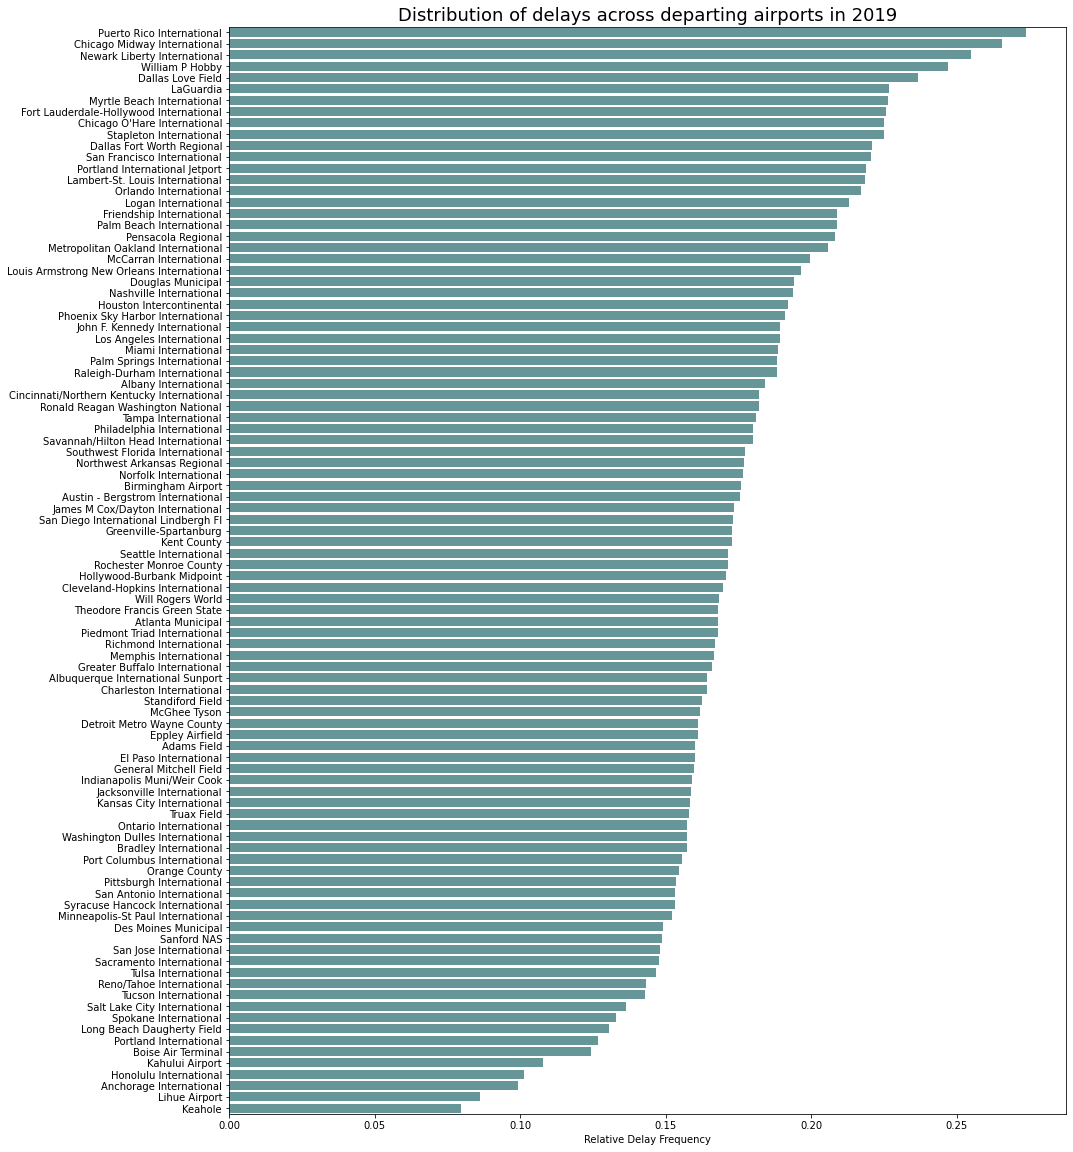

In [42]:
# Select departures grouped by DEPARTING_AIRPORT then compute the relative frequency of delays
delay_df = df.groupby(['DEPARTING_AIRPORT'])['DEP_DEL15'].value_counts(normalize=True).sort_values(ascending=False)

# Select only delayed flights
delay_df = delay_df.iloc[delay_df.index.get_level_values('DEP_DEL15') == 1]

# Get x and y axis from the delay_df series
x = delay_df.values
y = delay_df.index.get_level_values('DEPARTING_AIRPORT')

# Plot the distribution of delays
ax = plt.subplots(figsize=(15,20))
ax = sns.barplot(x=x,y=y,color='cadetblue',orient="h")
ax.set_title('Distribution of delays across departing airports in 2019', fontdict={'fontsize':18})
ax.set_xlabel("Relative Delay Frequency"), ax.set_ylabel("");

**Summary of EDA findings**

* According to the correlation matrix, `SEGMENT_NUMBER` and `PRCP` have the largest positive correlation with target class `DEP_DEL15`.
* Three highly correlated features were removed: `AVG_MONTHLY_PASS_AIRLINE`, `AVG_MONTHLY_PASS_AIRPORT`, `CONCURRENT_FLIGHTS`.
* The largest number of departure delays occur in June and on Thursday.
* Airlines with the largest relative delay frequency of delays are Frontier and Jetblue.
* Top three departing airports with the largest relative delay frequency are Puerto Rico Intl., Chicago Midway, and Newark Liberty
* There may be differences between mean weather conditions for delayed and on-time departures, but some have rather high variance.

**Discussion of forseen difficulties**

The main difficulty that I foresee at this point will be working with the abundance of features. While I have removed some redundant numeric features with the correlation matrix, I did not eliminate any categorical variables. I will need figure out the best approach to do this, perhaps by kendall's correlation or by ANOVA. I will also need to fopcus on feature selection techniques and dimensonality reduction, such as principal component analysis or linear discriminant analysis. Overall, in spite of these difficulties, I think this dataset still has two key advantages: (1) the target class is binary, which may simplify the classification task; and (2) there are an abundance of data points to work with. 